<a href="https://colab.research.google.com/github/davetew/Modern-Aerospace-Propulsion/blob/main/Cycle_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cycle Analysis
This notebook contains analyses and plotting routines that were used to develop lecture 3 of the Mechanics and Thermodynamics of Propulsion course.

In [7]:
# Import the required python packages
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # Mac retina display resolution for plots

# Set matplotlib text sizes that are appropriate for a presentation
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 14,
})

import pandas as pd

## Propulsive Efficiency
The propulsive efficiency of a jet engine is a measure of the efficiency with which net exhaust kinetic energy is converted to thrust energy.

$$\eta_{propulsive}=\frac{TV_\infty}{\Delta KE}$$

For a fully expanded nozzle and neglecting the contribution of the fuel mass flow to thrust, the expression for $\eta_{propulsive}$ may be simplified to the below--

$$\eta_{propulsive}=\frac{2}{\frac{V_{exit}}{V_\infty}+1}$$

## Dimensionless Specific Thrust $\left(\frac{T}{\dot{m}_{air}V_\infty}\right)$
The dimensionless specific thrust may be expressed as follows for a fully expanded nozzle and by neglecting the contribution of the fuel mass flow to the thrust.

$$\frac{T}{\dot{m}_{air}V_\infty} = \frac{V_{exit}}{V_\infty} - 1$$

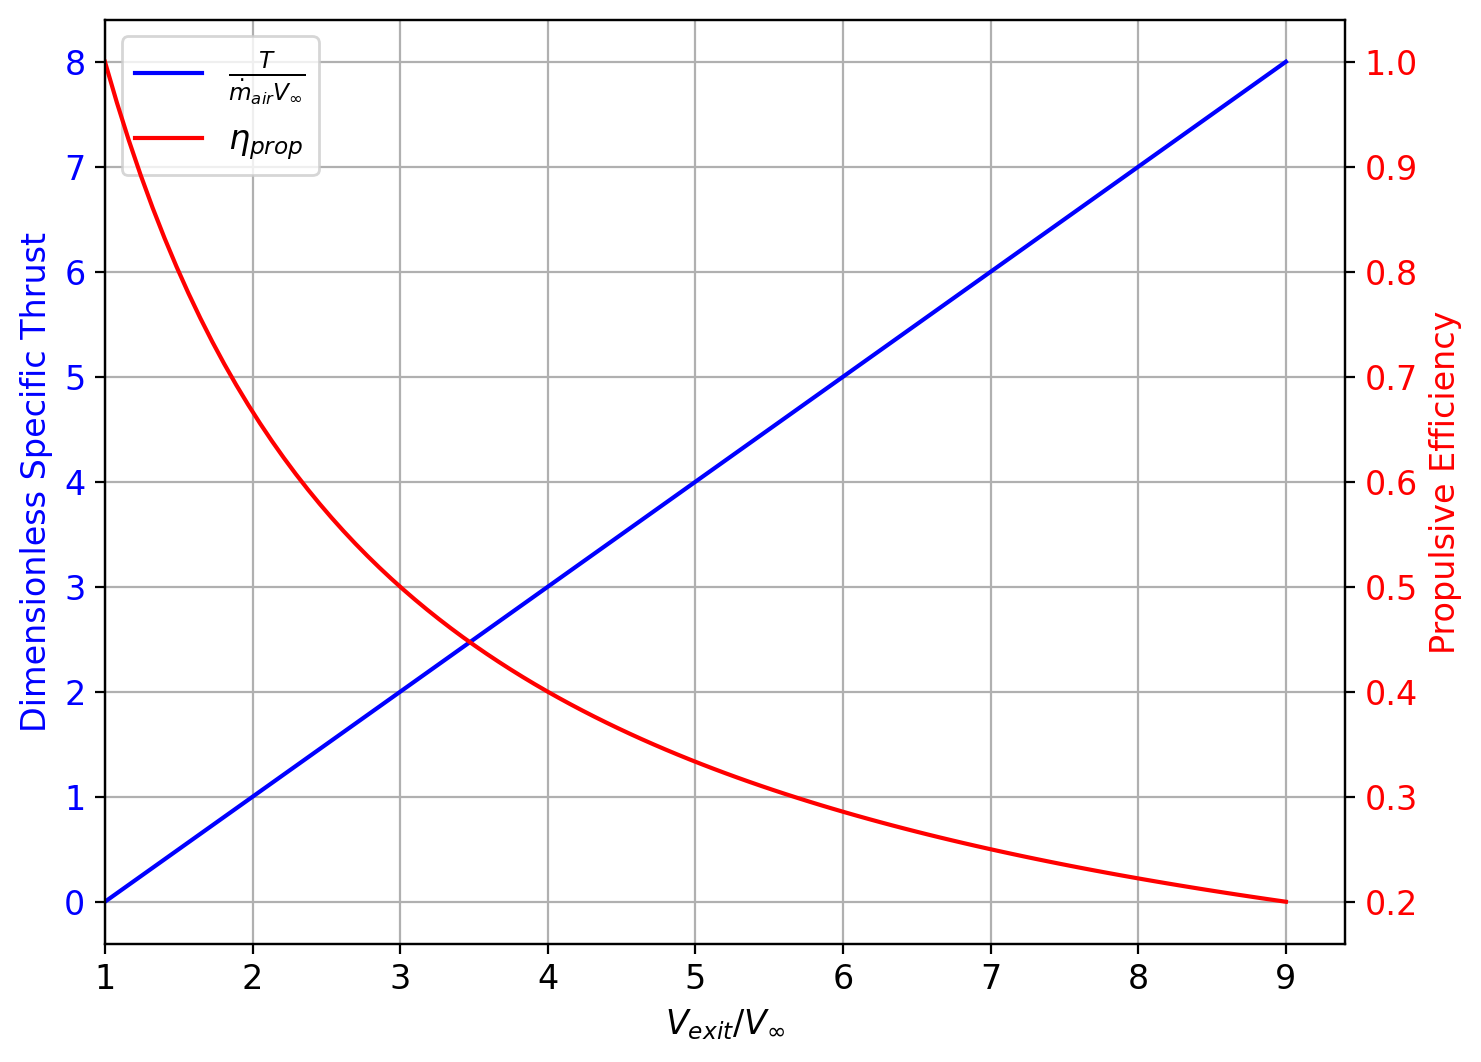

In [8]:
# Plot the propulsive efficiency & the dimensionless specific thrust vs Vexit_Vflight
Vexit_Vflight = np.linspace(1, 9, 100)

# Dimensionless specific thrust
ST = lambda Vexit_Vflight: Vexit_Vflight - 1

# Propulsive efficiency
eta_prop = lambda Vexit_Vflight: 2/(1 + Vexit_Vflight)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(Vexit_Vflight, ST(Vexit_Vflight), label=r'$\frac{T}{\dot{m}_{air}V_\infty}$', color="blue")
ax.set_xlabel(r'$V_{exit}/V_\infty$')
ax.set_ylabel('Dimensionless Specific Thrust', color="blue")

# Start the lower x limit to one
ax.set_xlim(1, None)

ax2 = ax.twinx()
ax2.plot(Vexit_Vflight, eta_prop(Vexit_Vflight), label=r'$\eta_{prop}$', color="red")
ax2.set_ylabel('Propulsive Efficiency', color="red")

# Color the tick labels to match the axis label
ax.tick_params(axis='y', labelcolor="blue")
ax2.tick_params(axis='y', labelcolor="red")

# Combine the two legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0)

ax.grid()
plt.show()

## Turobjet Performance
In the section below, a simple model of a turbojet is employed to estimate its dimensionless specific thrust and overall efficiency as a function of the flight Mach number.

In the derivation of the model, the below simplifying assumptions have been made--
*   Isentropic inlet & nozzle
*   Fully expanded nozzle
*   Neglect fuel mass flow contribution to thrust
*   No turbine cooling air
*   Constant pressure combustion
*   Constant gas properties (*i.e.,* $\gamma$, $R$)

Also, the following parameters are assumed to be known,
*   Flight Mach number ($M_∞$)
*   Compressor isentropic efficiencie ($\eta_{c}$ )
*   Turbine isentropic efficiency ($\eta_{t}$)
*   Compressor pressure ratio ($\pi_{c}$)
*   Fuel air ratio ($f$)
*   Fuel lower heating value ($LHV_{f}$)






In [13]:
# Compressible Flow Relations

ga1 = lambda ga: ga / (ga - 1)

theta = lambda M, ga: 1 + (ga-1)/2*M**2

delta = lambda M, ga: theta(M, ga)**ga1(ga)


In [60]:
class SimpleTurbojet():

  # Air properties
  ga = 1.4
  ga1 = ga / (ga-1)
  R_air = 287.05 # J/kg/K
  cp_air = ga / (ga-1) * R_air # J/kg/K

  def __init__(self, M_inf: float = 0.8, eta_comp: float = 1.0,
               eta_turb: float = 1.0, pi_comp: float = 50,
               f: float = 0.025, LHV_f: float = 43.7, T_inf_K: float = 273) -> None:
    """Initialized an instance of the Turbojet class given
    M_inf - float: Flight Mach Number
    eta_c - float: Compressor isentropic efficiency
    eta_t - float: Turbine isentropic efficiency
    pi_c - float: Compressor total presssure ratio
    f - float: Fuel air ratio
    LHV_f - float: Lower heating value of the fuel in MJ/kg"""
    self.M_inf = M_inf
    self.eta_comp = eta_comp
    self.eta_turb = eta_turb
    self.pi_comp = pi_comp
    self.f = f
    self.LHV_f = LHV_f * 1e6 # Convert MJ/kg to J/kg
    self.T_inf_K = T_inf_K

  @property
  def tau_comp(self) -> float:
    """Compresssor total temperature ratio"""
    return 1 + (self.pi_comp**(1/self.ga1) - 1)/self.eta_comp

  @property
  def tau_burner(self) -> float:
    """Burner total temperature ratio"""
    Tt_inf = self.T_inf_K / theta(self.M_inf, self.ga)
    return 1 + 1 / self.tau_comp * self.f * self.LHV_f / self.cp_air / Tt_inf

  @property
  def tau_turb(self) -> float:
    """Turbine total temperature ratio"""
    return 1 - (self.tau_comp - 1)/self.tau_burner/self.tau_comp

  @property
  def pi_turb(self) -> float:
    """Turbine total pressure ratio"""
    return (1 + (self.tau_turb - 1)/self.eta_turb)**self.ga1

  @property
  def M_exit(self) -> float:
    """Nozzle exit Mach number"""
    return np.sqrt(2/(self.ga-1)*((self.pi_turb*self.pi_comp)**(1/self.ga1)*theta(self.M_inf, self.ga) - 1))

  @property
  def thrust(self) -> float:
    """Dimensionless specific thrust"""
    return self.M_exit / self.M_inf * np.sqrt( theta(self.M_inf, self.ga)/theta(self.M_exit,self.ga) *
                                              self.tau_turb * self.tau_burner * self. tau_comp ) - 1

  @property
  def eta_overall(self) -> float:
    """Overall efficiency"""
    return self.thrust / self.f * self.M_inf**2 * self.ga * self.R_air * self.T_inf_K / self.LHV_f

  @property
  def design(self) -> pd.Series:
    """Return a summary of the turbojet design"""
    return pd.Series({"M_inf": self.M_inf,
                      "eta_comp": self.eta_comp,
                      "eta_turb": self.eta_turb,
                      "pi_comp": self.pi_comp,
                      "f": self.f,
                      "LHV_f": self.LHV_f})

  @property
  def performance(self) -> pd.Series:
    """Return a summary of the turbojet performance"""
    return pd.Series({"thrust": self.thrust,
                      "overall efficiency": self.eta_overall,
                      "tau_comp": self.tau_comp,
                      "tau_burner": self.tau_burner,
                      "tau_turb": self.tau_turb,
                      "pi_turb": self.pi_turb,
                      "M_exit": self.M_exit})


In [61]:
display(SimpleTurbojet().design)
display(SimpleTurbojet().performance)

,0
M_inf,8.000000e-01
eta_comp,1.000000e+00
eta_turb,1.000000e+00
pi_comp,5.000000e+01
f,2.500000e-02
LHV_f,4.370000e+07


,0
thrust,4.395913
overall efficiency,0.282524
tau_comp,3.057877
tau_burner,2.469340
tau_turb,0.727467
pi_turb,0.328358
M_exit,2.747037


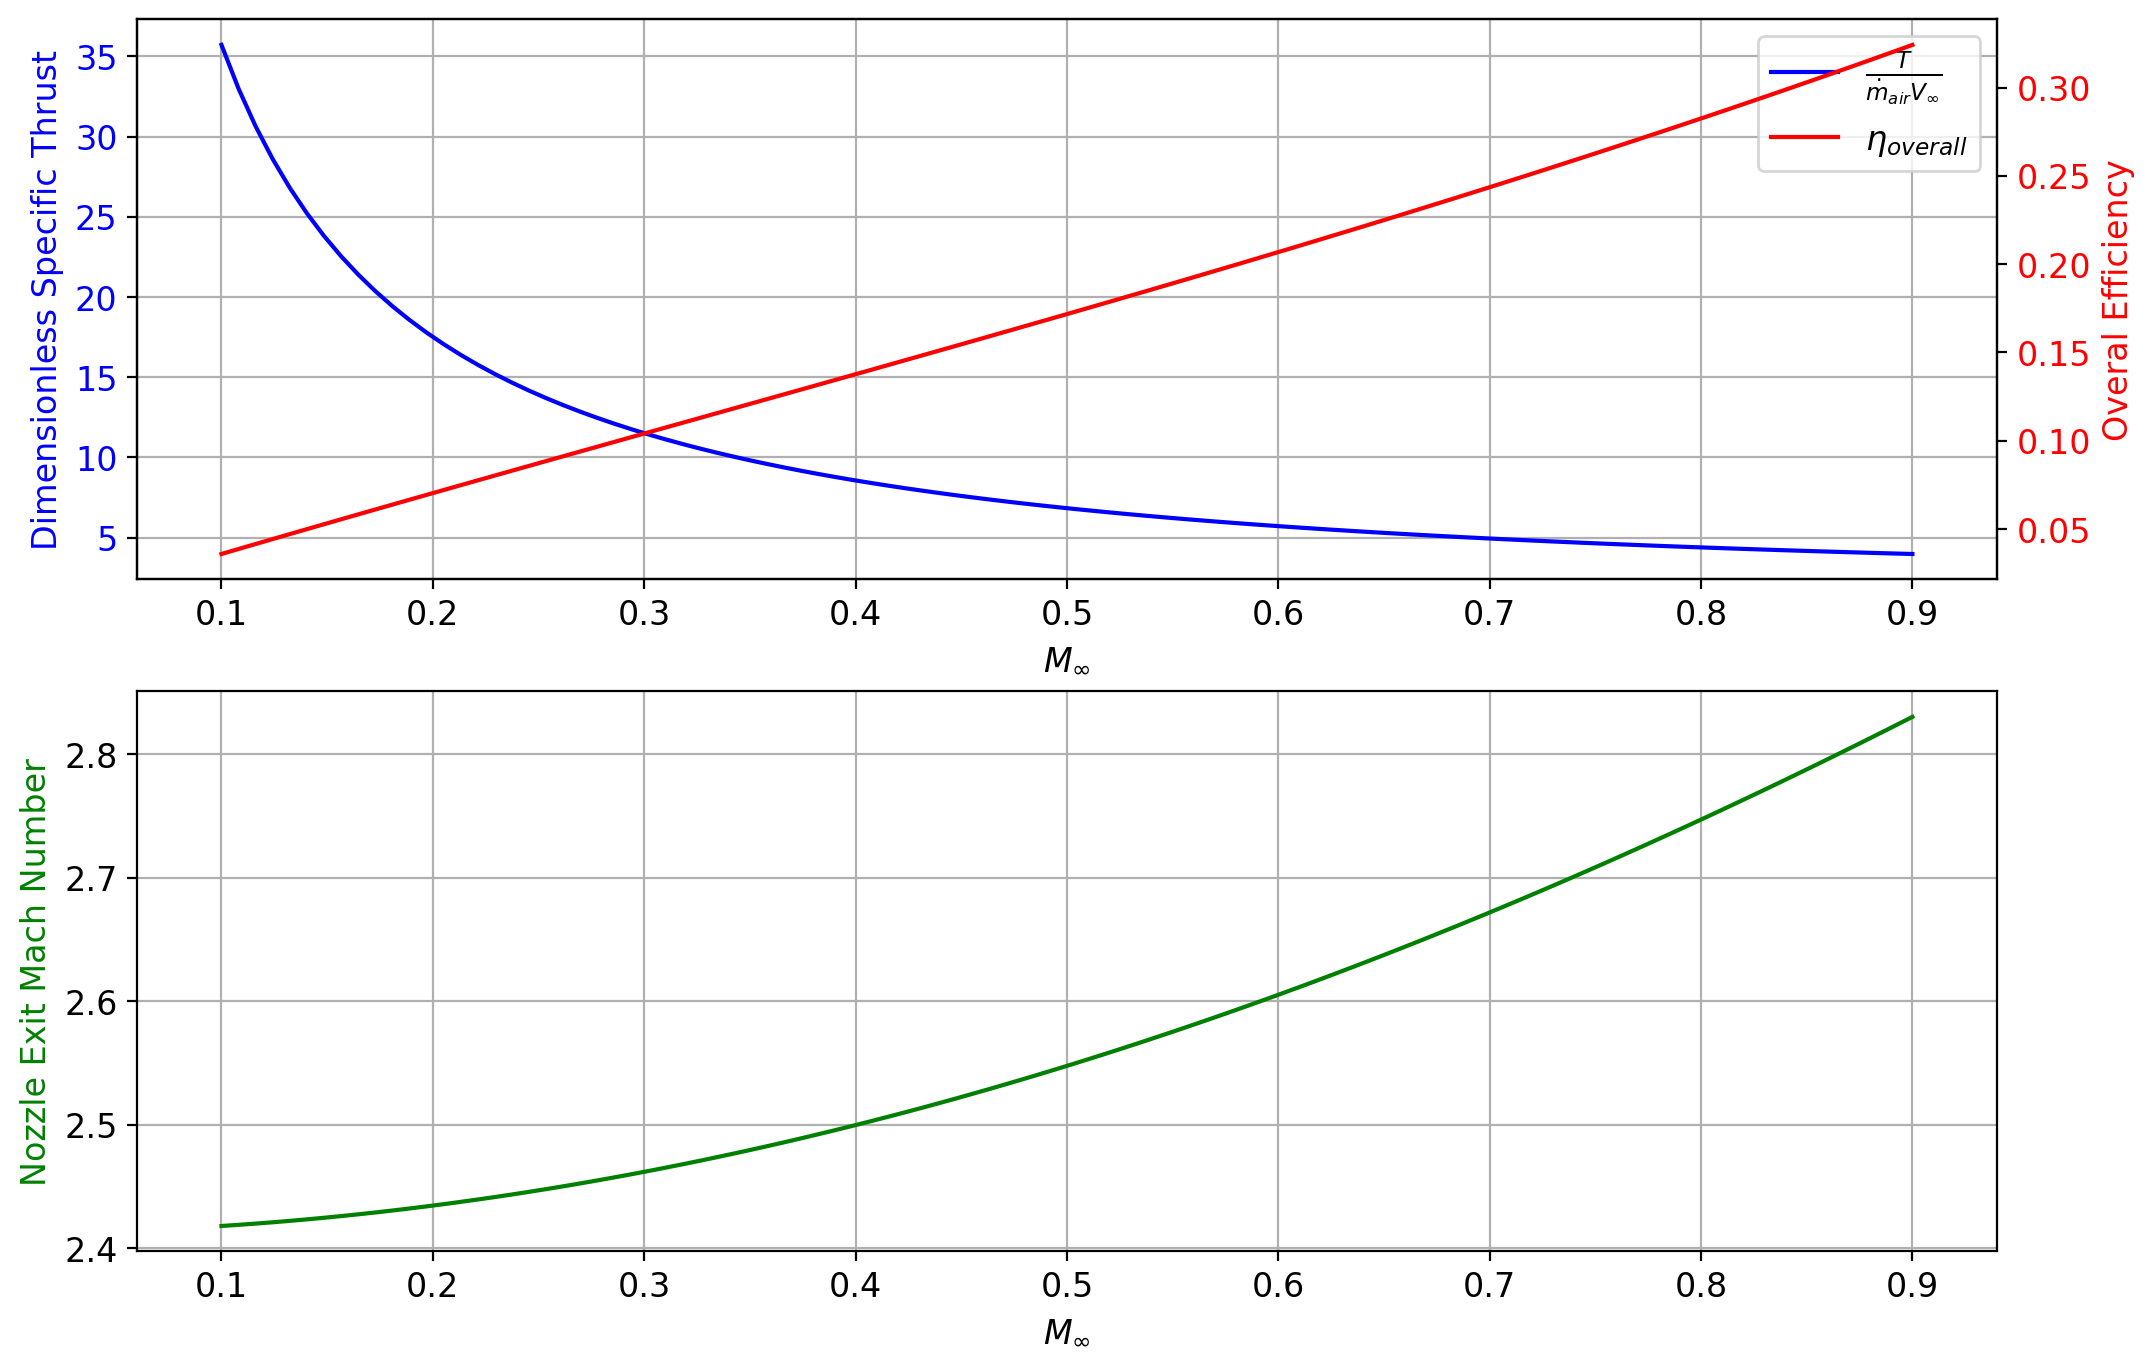

In [63]:
# Plot the specific thrust and overall efficiency vs Mach number
Mach = np.linspace(0.1, 0.9, 100)
ST = lambda M: SimpleTurbojet(M_inf=M).thrust
eta_overall = lambda M: SimpleTurbojet(M_inf=M).eta_overall
M_exit = lambda M: SimpleTurbojet(M_inf=M).M_exit

fig, ax = plt.subplots(2,1, figsize=(12, 8))
ax[0].plot(Mach, ST(Mach), label=r'$\frac{T}{\dot{m}_{air}V_\infty}$', color="blue")
ax[0].set_xlabel(r'$M_\infty$')
ax[0].set_ylabel('Dimensionless Specific Thrust', color="blue")

ax2 = ax[0].twinx()
ax2.plot(Mach, eta_overall(Mach), label=r'$\eta_{overall}$', color="red")
ax2.set_ylabel('Overal Efficiency', color="red")

# Color the tick labels to match the axis label
ax[0].tick_params(axis='y', labelcolor="blue")
ax2.tick_params(axis='y', labelcolor="red")

# Combine the two legends
lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax[0].legend(lines + lines2, labels + labels2, loc=0)
ax[0].grid()

ax[1].plot(Mach, M_exit(Mach), label=r'$M_{exit}$', color="green")
ax[1].set_xlabel(r'$M_\infty$')
ax[1].set_ylabel('Nozzle Exit Mach Number', color="green")
ax[1].grid()
plt.show()
